<center> <font size = 6> Predict overweight levels and obesity levels based on lifestyles and eating habits </font></center>

### Table of contents

- [Preprocessing of data](#preprocessing)
- [Multilabel neural network](#neural_network)
- [Multilabel logistic regression with TensorFlow](#logistic_w_tf)
- [Multilabel Random Forest Decision Tree](#random_forest)
- [Comparison the lifestyles and eating habits between normal weight individuals and obese individuals](#comparison)

<a id='preprocessing'></a>
### I. Preprocessing of data.

In [1]:
import pandas as pd
df=pd.read_csv("Obesity_data.csv")
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


There are several non-numeric attributes that needs to be either one-hot encoded or label-encoded. Let's see how many unique classes are in each of those non-numeric attributes.

In [2]:
import numpy as np
print("Gender: ", np.unique(df[["Gender"]]))
print("family_history_with_overweight: ",np.unique(df[["family_history_with_overweight"]]))
print("FAVC: ", np.unique(df[["FAVC"]]))
print("SMOKE: ", np.unique(df[["SMOKE"]]))
print("SCC: ", np.unique(df[["SCC"]]))
print("CAEC: ", np.unique(df[["CAEC"]]))
print("CALC: ", np.unique(df[["CALC"]]))
print("MTRANS: ", np.unique(df[["MTRANS"]]))
print("NObeyesdad", np.unique(df[["NObeyesdad"]]))

Gender:  ['Female' 'Male']
family_history_with_overweight:  ['no' 'yes']
FAVC:  ['no' 'yes']
SMOKE:  ['no' 'yes']
SCC:  ['no' 'yes']
CAEC:  ['Always' 'Frequently' 'Sometimes' 'no']
CALC:  ['Always' 'Frequently' 'Sometimes' 'no']
MTRANS:  ['Automobile' 'Bike' 'Motorbike' 'Public_Transportation' 'Walking']
NObeyesdad ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


All non-numeric variables are categorical variables or non-cardinal variables. We are going to apply one-hot encoding to these categorical variables and standardize the numeric variables.

There are 17-1 = 16 predictor variables. Some of the predictors might not be relevant. We are going to run a feature selection algorithm and output the feature importance scores. Before that, we need to one-hot encode the categorical variables. If we don't we are going to get an error saying that "cannot covert strings to floats". The "strings" are the categorical variables.

Standardize the numeric predictor variables.

In [3]:
from sklearn import preprocessing
numeric_predictors=df[["Age","Height","Weight","FCVC","NCP","CH2O","FAF","TUE"]]
names=numeric_predictors.columns
scaler=preprocessing.StandardScaler()
numeric_predictors=scaler.fit_transform(numeric_predictors)
numeric_predictors=pd.DataFrame(numeric_predictors,columns=names)
numeric_predictors.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625


One-hot encode the categorical predictors.

In [4]:
categorical_predictors=df[["Gender","family_history_with_overweight","FAVC","CAEC","SMOKE","CALC","MTRANS"]]
from sklearn.preprocessing import OneHotEncoder
ienc=OneHotEncoder(handle_unknown="ignore")
categorical_predictors=ienc.fit_transform(categorical_predictors)
categorical_predictors=pd.DataFrame(categorical_predictors.toarray())
categorical_predictors.head()


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
X=pd.concat([numeric_predictors,categorical_predictors],axis=1)
X.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,0,1,...,11,12,13,14,15,16,17,18,19,20
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


After one-hot encoding, the predictor set has 29 columns (or attributes). We are going to select the first 15. To do that, we output the 15 largest feature importance scores.

In [6]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

y=df[["NObeyesdad"]]

test=SelectKBest(score_func=mutual_info_classif,k="all")
fit=test.fit(X,y)
features=fit.transform(X)
set_printoptions(precision=3)

scores=fit.scores_
scores=pd.DataFrame(scores)
scores=scores.rename(columns={0:"scores"})
scores.sort_values(by=["scores"],ascending=False).nlargest(15,"scores")

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,scores
2,1.263783
0,0.589299
1,0.420364
3,0.380155
6,0.301670
5,0.287182
7,0.284436
4,0.267063
9,0.218379
8,0.199268


Select the columns from the original predictor set to form the new predictor set that would be used.

In [7]:
X=X.iloc[:,[2,0,1,3,5,6,7,4,8,9,11,10,16,22,15]]
X.head()

,Weight,Age,Height,FCVC,CH2O,FAF,TUE,NCP,0,1,3,2,8,14,7
0,-0.862558,-0.522124,-0.875589,-0.785019,-0.013073,-1.188039,0.561997,0.404153,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.168077,-0.522124,-1.947599,1.088342,1.618759,2.339750,-1.080625,0.404153,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,-0.366090,-0.206889,1.054029,-0.785019,-0.013073,1.163820,0.561997,0.404153,0.0,1.0,1.0,0.0,1.0,0.0,0.0
3,0.015808,0.423582,1.054029,1.088342,-0.013073,1.163820,-1.080625,0.404153,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.122740,-0.364507,0.839627,-0.785019,-0.013073,-1.188039,-1.080625,-2.167023,0.0,1.0,0.0,1.0,1.0,1.0,0.0


One-hot encode the target variable.

In [8]:
y=df[["NObeyesdad"]]
from sklearn.preprocessing import OneHotEncoder
ienc=OneHotEncoder(handle_unknown="ignore")
y=ienc.fit_transform(y)
y=pd.DataFrame(y.toarray())
y.head()

,0,1,2,3,4,5,6
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Split the data into train and test subsets.

In [37]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test=train_test_split(X,y,test_size=0.15,random_state=12)
print(X_train.shape)
print(X_test.shape)

(1794, 15)
(317, 15)


<a id='neural_network'></a>
### II. Multilabel neural network

Build, train and test the model.

In [38]:
length=X_train.shape[1]
num_classes=y_test.shape[1]

import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense

# define classification model

def classification_model():
    # create model
    model = Sequential()
    model.add(Dense(length, activation='relu', input_shape=(length,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50,activation="relu"))
    model.add(Dense(50,activation="relu"))
    model.add(Dense(50,activation="tanh"))
    model.add(Dense(num_classes, activation='softmax'))
      
    # compile model
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [39]:
model=classification_model()
model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=22, verbose=2)
model.evaluate(X_test,y_test,verbose=0)

Train on 1794 samples, validate on 317 samples
Epoch 1/22
 - 4s - loss: 1.7682 - acc: 0.3166 - val_loss: 1.4290 - val_acc: 0.4511
Epoch 2/22
 - 1s - loss: 1.0505 - acc: 0.5819 - val_loss: 0.8742 - val_acc: 0.5994
Epoch 3/22
 - 1s - loss: 0.6665 - acc: 0.7542 - val_loss: 0.5953 - val_acc: 0.7413
Epoch 4/22
 - 1s - loss: 0.4799 - acc: 0.8356 - val_loss: 0.4504 - val_acc: 0.7918
Epoch 5/22
 - 1s - loss: 0.3665 - acc: 0.8813 - val_loss: 0.3264 - val_acc: 0.9054
Epoch 6/22
 - 2s - loss: 0.3230 - acc: 0.9019 - val_loss: 0.2840 - val_acc: 0.9211
Epoch 7/22
 - 1s - loss: 0.2546 - acc: 0.9275 - val_loss: 0.3004 - val_acc: 0.9022
Epoch 8/22
 - 1s - loss: 0.2299 - acc: 0.9309 - val_loss: 0.2311 - val_acc: 0.9117
Epoch 9/22
 - 1s - loss: 0.1885 - acc: 0.9415 - val_loss: 0.1824 - val_acc: 0.9527
Epoch 10/22
 - 1s - loss: 0.1761 - acc: 0.9459 - val_loss: 0.1744 - val_acc: 0.9432
Epoch 11/22
 - 1s - loss: 0.1517 - acc: 0.9521 - val_loss: 0.1416 - val_acc: 0.9590
Epoch 12/22
 - 1s - loss: 0.1423 - acc

[0.10792465103137944, 0.9621451104100947]

The  neural network model has a 96.2% accuracy on test data. Not bad. 

<a id='logistic_w_tf'></a>
### III. Multilabel logistic regression with TensorFlow

Let's try TensorFlow as well. **Restart the kernel and re-run the code blocks up to the code block the separates the data for training and test purpose. Reset the train-test split.**

In [10]:
import tensorflow as tf
# numFeatures is the number of features in our input data.
numFeatures = X_train.shape[1]

# numLabels is the number of classes our data points can be in.
numLabels = y_train.shape[1]


# Placeholders
# 'None' means TensorFlow shouldn't expect a fixed number in that dimension
X = tf.placeholder(tf.float32, [None, numFeatures]) 
yGold = tf.placeholder(tf.float32, [None, numLabels]) 

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyterlab/conda/envs/python/lib/python3

In [11]:
weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=0.001,
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=0.001,
                                    name="bias"))

In [12]:
# Three-component breakdown of the Logistic Regression equation.
# Note that these feed into each other.
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

In [13]:
# Number of Epochs in our training
numEpochs = 50000

# Defining our learning rate iterations (decay)
learningRate = tf.train.exponential_decay(learning_rate=0.0001,
                                          global_step= 1,
                                          decay_steps=X_train.shape[0],
                                          decay_rate= 0.9,
                                          staircase=True)

In [14]:
#Defining our cost function - Squared Mean Error
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

#Defining our Gradient Descent
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

In [15]:
# Create a tensorflow session
sess = tf.Session()

# Initialize our weights and biases variables.
init_OP = tf.global_variables_initializer()

# Initialize all tensorflow variables
sess.run(init_OP)

In [16]:
# argmax(activation_OP, 1) returns the label with the most probability
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))

# If every false prediction is 0 and every true prediction is 1, the average returns us the accuracy
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)

# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)

# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)

# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))

# Merge all summaries
merged = tf.summary.merge([activation_summary_OP, accuracy_summary_OP, cost_summary_OP, weightSummary, biasSummary])

# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

In [17]:
# Initialize reporting variables
cost = 0
diff = 1
epoch_values = []
accuracy_values = []
cost_values = []

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: X_train, yGold: y_train})
        # Report occasional stats
        if i % 1000 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            train_accuracy, newCost = sess.run([accuracy_OP, cost_OP], feed_dict={X: X_train, yGold: y_train})
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g, cost %g, change in cost %g"%(i, train_accuracy, newCost, diff))


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: X_test, 
                                                                yGold: y_test})))

step 0, training accuracy 0.483278, cost 1504.89, change in cost 1504.89
step 1000, training accuracy 0.63155, cost 476.217, change in cost 1028.68
step 2000, training accuracy 0.670011, cost 445.928, change in cost 30.2888
step 3000, training accuracy 0.687848, cost 430.748, change in cost 15.1806
step 4000, training accuracy 0.694537, cost 421.33, change in cost 9.4176
step 5000, training accuracy 0.701784, cost 414.843, change in cost 6.48734
step 6000, training accuracy 0.705686, cost 410.064, change in cost 4.7785
step 7000, training accuracy 0.708473, cost 406.375, change in cost 3.68954
step 8000, training accuracy 0.70903, cost 403.423, change in cost 2.95151
step 9000, training accuracy 0.711817, cost 400.998, change in cost 2.42578
step 10000, training accuracy 0.715162, cost 398.96, change in cost 2.03754
step 11000, training accuracy 0.718506, cost 397.218, change in cost 1.74194
step 12000, training accuracy 0.719064, cost 395.707, change in cost 1.51083
step 13000, traini

The logistic regression model with TensorFlow performed miserably, with an accuracy of only 71% on the test data.

<a id='random_forest'></a>
### IV. Random Forest Decision Tree

Let's also try Random Forest decision tree. **Re-start the kernel and re-run the code blocks up to where it splits the data for training and test purposes.**

In [36]:
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier(criterion="entropy", max_depth = 25,random_state=42,min_samples_split=15)
RandomForest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [37]:
RandomForest.fit(X_train,y_train)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [38]:
from sklearn import metrics
import matplotlib.pyplot as plt
y_pred=RandomForest.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, y_pred))

DecisionTrees's Accuracy:  0.7767253044654939


The neural network model delivered commendable result on test data. However, the logistic regression model with TensorFlow and the Random Forest Decision Tree model performed miserably. We could have stopped after the neural network model. Most of the time, a neural network model outperforms other models.

<a id='comparison'></a>
### V. Comparsion of the lifestyles and eating habits of normal weight individuals and obese individuals.

Let's compare the lifestyles and eating habits of the obesed individuals and the individuals with normal weights.

In [72]:
obesity_I=df[df["NObeyesdad"]=="Obesity_Type_I"]
obesity_II=df[df["NObeyesdad"]=="Obesity_Type_II"]
obesity_III=df[df["NObeyesdad"]=="Obesity_Type_III"]
obesity=pd.concat([obesity_I, obesity_II, obesity_III],axis=0)
obesity


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
10,Male,26.000000,1.850000,105.000000,yes,yes,3.0,3.0,Frequently,no,3.000000,no,2.000000,2.000000,Sometimes,Public_Transportation,Obesity_Type_I
13,Male,41.000000,1.800000,99.000000,no,yes,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Automobile,Obesity_Type_I
17,Female,29.000000,1.530000,78.000000,no,yes,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,no,Automobile,Obesity_Type_I
21,Female,52.000000,1.690000,87.000000,yes,yes,3.0,1.0,Sometimes,yes,2.000000,no,0.000000,0.000000,no,Automobile,Obesity_Type_I
23,Female,22.000000,1.600000,82.000000,yes,yes,1.0,1.0,Sometimes,no,2.000000,no,0.000000,2.000000,Sometimes,Public_Transportation,Obesity_Type_I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


We are going to plot how the categorical variables that describe the lifestyles and eating habits the obesed individuals. Simply plotting the counts can be misleading. For example, there dataset may include many more non-smokers than smokers. If we simply plot the counts, it might lead to the mis-conclusion that smokers are less likely to be obesed. Hence, we are going to plot the percentage relative to the toal number of obesed individuals.

In [75]:
SCC = obesity[obesity["SCC"]=="yes"]
print("Proportion of obesed individuals who monitored their calorie consumption is: ", len(SCC)/len(obesity))

family_history=obesity[obesity["family_history_with_overweight"]=="yes"]
print("Proportion of obesed individual with family history of overweight is: ", len(family_history)/len(obesity))

MTRANS_public=obesity[obesity["MTRANS"]=="Public_Transportation"]
MTRANS_auto=obesity[obesity["MTRANS"]=="Automobile"]
print("Proportion of obesed individuals who took public transportation or drove is: ", (len(MTRANS_public)+len(MTRANS_auto))/len(obesity))

print("Average frequency of consumption of vegetables for obesed individuals (FCVC): ",obesity[["FCVC"]].mean())
print("Numer of main meals for obesed individuals (NCP): ",obesity[["NCP"]].mean())
print("Consumption of water daily (CH20): ", obesity[["CH2O"]].mean())
print("Physical activity frequency (FAF): ", obesity[["FAF"]].mean())
print("Time using technology devices (TUE): ",obesity[["TUE"]].mean())

FAVC=obesity[obesity["FAVC"]=="yes"]
print("Frequent consumption of high caloric food (FAVC): ",len(FAVC)/len(obesity))

CAEC=obesity[obesity["CAEC"]=="no"]
print("Consumption of food between meals (CAEC): ", (len(obesity)-len(CAEC))/len(obesity) )

CALC=obesity[obesity["CALC"]=="no"]
print("Consumption of alcohol: ",(len(obesity)-len(CALC))/len(obesity))

Proportion of obesed individuals who monitored their calorie consumption is:  0.0030864197530864196
Proportion of obesed individual with family history of overweight is:  0.9917695473251029
Proportion of obesed individuals who took public transportation or drove is:  0.992798353909465
Average frequency of consumption of vegetables for obesed individuals (FCVC):  FCVC    2.520077
dtype: float64
Numer of main meals for obesed individuals (NCP):  NCP    2.716786
dtype: float64
Consumption of water daily (CH20):  CH2O    2.072639
dtype: float64
Physical activity frequency (FAF):  FAF    0.874888
dtype: float64
Time using technology devices (TUE):  TUE    0.603338
dtype: float64
Frequent consumption of high caloric food (FAVC):  0.9804526748971193
Consumption of food between meals (CAEC):  0.9979423868312757
Consumption of alcohol:  0.7561728395061729


In [77]:
normal=df[df["NObeyesdad"]=="Normal_Weight"]
normal

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
6,Female,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,Male,25.0,1.66,68.0,no,yes,2.0,3.0,Sometimes,yes,1.0,no,1.0,1.0,Sometimes,Public_Transportation,Normal_Weight
493,Male,20.0,1.80,65.0,no,yes,2.0,3.0,Frequently,no,1.0,no,2.0,0.0,Sometimes,Motorbike,Normal_Weight
494,Female,18.0,1.67,66.0,no,yes,3.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Normal_Weight
495,Male,19.0,1.80,60.0,yes,yes,3.0,1.0,Always,no,1.0,yes,0.0,0.0,no,Motorbike,Normal_Weight


In [78]:
SCC = normal[normal["SCC"]=="yes"]
print("Proportion of normal weight individuals who monitored their calorie consumption is: ", len(SCC)/len(normal))

family_history=normal[normal["family_history_with_overweight"]=="yes"]
print("Proportion of normal weight individual with family history of overweight is: ", len(family_history)/len(normal))

MTRANS_public=normal[normal["MTRANS"]=="Public_Transportation"]
MTRANS_auto=normal[normal["MTRANS"]=="Automobile"]
print("Proportion of normal weight individuals who took public transportation or drove is: ", (len(MTRANS_public)+len(MTRANS_auto))/len(normal))

print("Average frequency of consumption of vegetables for obesed individuals (FCVC): ",normal[["FCVC"]].mean())
print("Numer of main meals for obesed individuals (NCP): ",normal[["NCP"]].mean())
print("Consumption of water daily (CH2O): ", normal[["CH2O"]].mean())
print("Physical activity frequency (FAF): ", normal[["FAF"]].mean())
print("Time using technology devices (TUE): ",normal[["TUE"]].mean())

FAVC=normal[normal["FAVC"]=="yes"]
print("Frequent consumption of high caloric food (FAVC): ",len(FAVC)/len(normal))

CAEC=normal[normal["CAEC"]=="no"]
print("Consumption of food between meals (CAEC): ", (len(obesity)-len(CAEC))/len(normal) )

CALC=normal[normal["CALC"]=="no"]
print("Consumption of alcohol: ",(len(obesity)-len(CALC))/len(normal))

Proportion of normal weight individuals who monitored their calorie consumption is:  0.10452961672473868
Proportion of normal weight individual with family history of overweight is:  0.5400696864111498
Proportion of normal weight individuals who took public transportation or drove is:  0.8536585365853658
Average frequency of consumption of vegetables for obesed individuals (FCVC):  FCVC    2.334495
dtype: float64
Numer of main meals for obesed individuals (NCP):  NCP    2.738676
dtype: float64
Consumption of water daily (CH2O):  CH2O    1.850174
dtype: float64
Physical activity frequency (FAF):  FAF    1.247387
dtype: float64
Time using technology devices (TUE):  TUE    0.675958
dtype: float64
Frequent consumption of high caloric food (FAVC):  0.7247386759581882
Consumption of food between meals (CAEC):  3.35191637630662
Consumption of alcohol:  3.013937282229965


Let's summarize the outputs above.

In [79]:
d = {'Obese': [0.0031,0.9918,0.9928,2.7168,2.0726,0.8749,0.6033,0.98045,0.9979, 0.75617], 'Normal weight': [0.1045, 0.5401,0.8537,2.7387,1.8502,1.2474,0.6760,0.7247,3.3519,3.0139]}
d = pd.DataFrame(data=d).T.rename(columns={0:"Monitor calorie consumption",1:"Family history",2:"Public transportation or drove",3:"Number of main meals (NCP)",4:"Daily consumption of water (CH2O)",5:"Physical activity frequency (FAF)",6:"Time using technology devices (TUE)",7:"Frequent consumption of high caloric food (FAVC)",8:"Consumption of food between meals (CAEC)",9:"Consumption of alcohol (CALC)"})
d

,Monitor calorie consumption,Family history,Public transportation or drove,Number of main meals (NCP),Daily consumption of water (CH2O),Physical activity frequency (FAF),Time using technology devices (TUE),Frequent consumption of high caloric food (FAVC),Consumption of food between meals (CAEC),Consumption of alcohol (CALC)
Obese,0.0031,0.9918,0.9928,2.7168,2.0726,0.8749,0.6033,0.98045,0.9979,0.75617
Normal weight,0.1045,0.5401,0.8537,2.7387,1.8502,1.2474,0.6760,0.72470,3.3519,3.01390


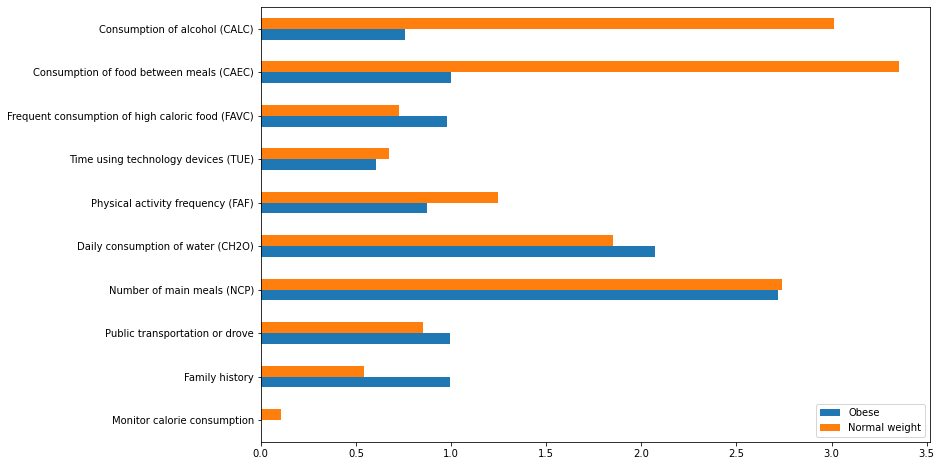

In [80]:
import matplotlib.pyplot as plt
d.T.plot(kind="barh",figsize=(12,8))
plt.show()

The statistics and the graph show a stark contrast between the lifestyles of the individuals who were normal weight and the ones who were obese. 

- Normal weight individuals are more likely to monitor their calorie consumption. More than 10% of the normal weight individuals monitor their calorie consumption, while less than 1% of obese individuals did the same thing.
- More than 99% of the obese individuals had family history of overweight, while only 54% of normal weight individuals had such family history.
- Normal weight individuals were more active. More than 99% of the obese individuals took public transportation or drove, while only slightly more than 85% of the normal individuals did the same. Normal weight individuals were more active. They were 15% more likely to ride a bike or walk.
- Normal weight individuals were much more likely to do physical activities.
- Normal weight individuals had more main meals. Normal weight individuals were also more likely to snack between meals. In other words, normal weight individuals even out their consumption of food, versus obese individuals who ate less ofen and had big meals.
- Normal weight individuals were less likely to consume high calorie food.

Several puzzling differences were also found, although it is not clear how these differences contributed to body weight.
- Normal weight individuals consumed more alcohol.
- Normal weight individual consumed less amount of water.
- Normal weight individual spent more time using technology devices.

We got a neural network model that can predict whether an individual will be underweight,normal weight, overweight level I, overweight level II, obesity type I, obesity type II, or obesity type III. The model has a 96.2% accuracy on test data. We also analyzed the lifestyles and eating habits of individuals with normal weight and individuals with obesity.

For exercise purpose, we also included two extra predictive model: logistic regression with TensorFlow and Random Forest Decision Tree. However, the performances of these two models are inferior to that of the neural network model. The logistic regression model with TensorFlow and the Random Forest Decision Tree model can be igored.